In [85]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
from sklearn.decomposition import PCA
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Data load
Hand cleaned to removed duplicates.  

In [99]:
cleansed=load_amihud_markets_price()
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

# PCA Analysis


In [100]:
ind=amihud['EUREX-EURO SCHATZ'].dropna().index
temp=amihud.ix[ind].dropna(axis=1)

In [107]:
amihud.count()

CME-3 MTH EURODOLLAR COMP.     205
SFE-AUST 90 DAY BANK BILLS     216
EUREX-EURO SCHATZ              216
SFE-30 DAY INTERBANK CASH      149
TIFFE-3 MTH EUROYEN TIBOR      216
EUREX-EURO BOBL                216
TSE-10 YEAR T-BOND             216
CBT-10 YRS US T-NOTE COMP.     216
ME-BANK ACCEPT. 90 DAY          92
CBT-5 YEAR US T-NOTE COMP.     216
CBT-2 YEAR US T-NOTE COMP.     216
Federal Funds                  205
CME-MINI S&P 500 INDEX         216
EuroSwiss                      205
SFE-AUST 10 YEAR T-BOND        216
LIFFE-3MTH STERLING            210
SFE-NZ 90 DAY BANK BILLS       216
CBT-30 YR US T-BOND COMP       216
EUREX-EURO BTP                  35
EUREX-DJ EURO STOXX 50         216
EUREX-LONG EURO OAT             56
KSE-KOSPI 200 INDEX            216
ME-10Y CANADIAN GOVT BOND       80
DAX                            206
LIFFE-LONG GILT                216
Cotton                         206
Russell 2000                   116
Nasdaq                         206
Corn                

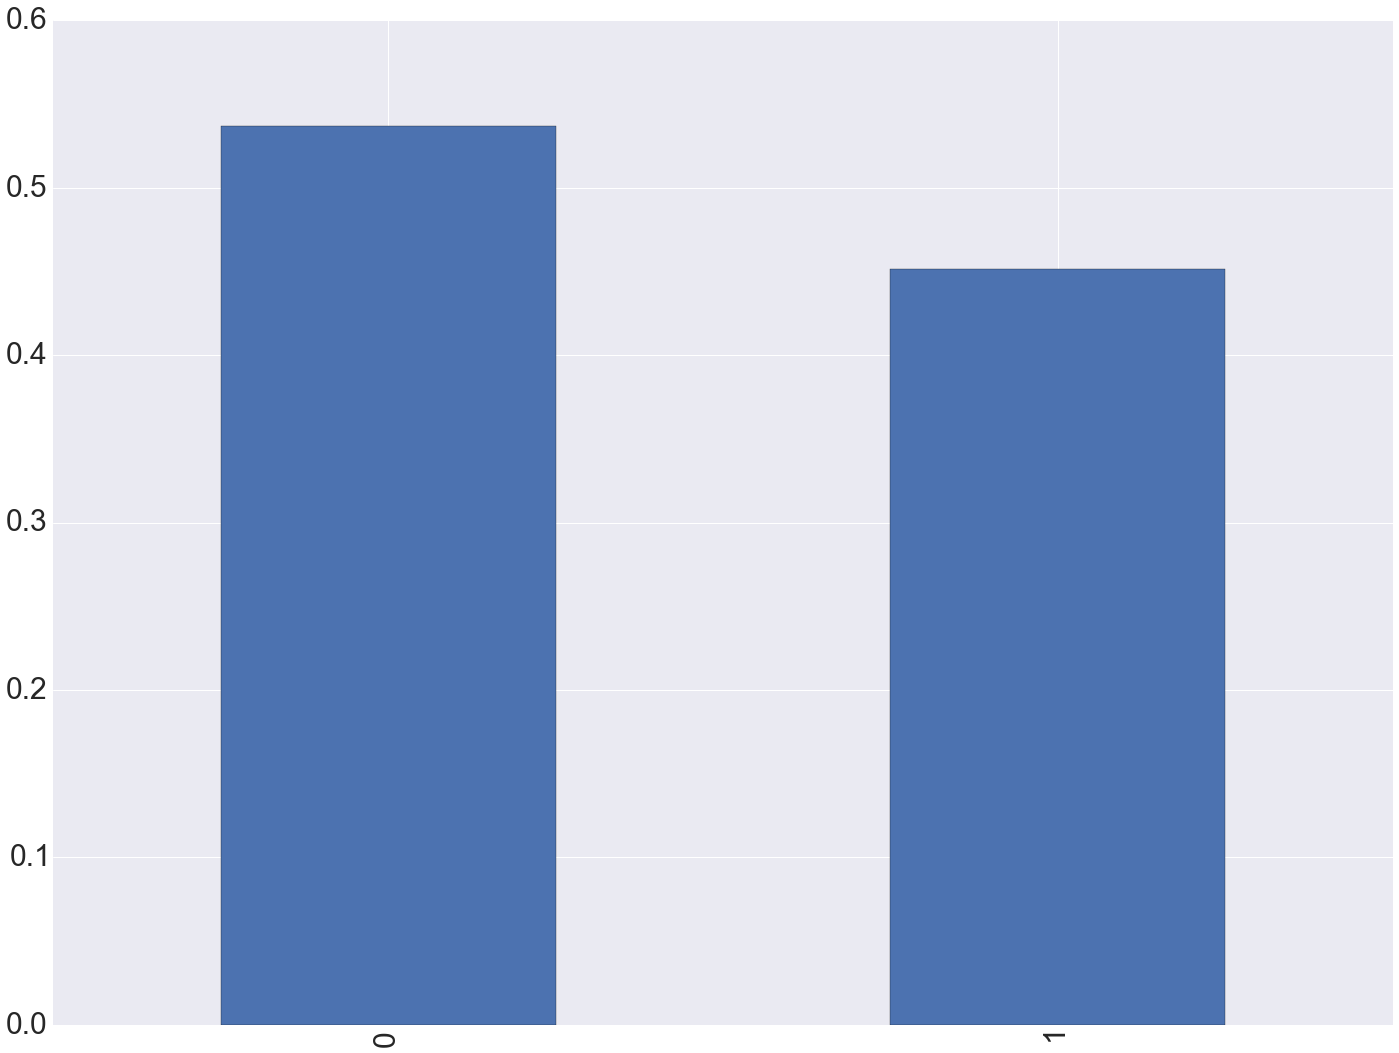

In [104]:
components=2
pca=PCA(n_components=components)
pca.fit(temp)
pd.Series(pca.explained_variance_ratio_).plot(kind='bar')

In [102]:
pca.explained_variance_ratio_

array([ 0.53691473,  0.45120696])

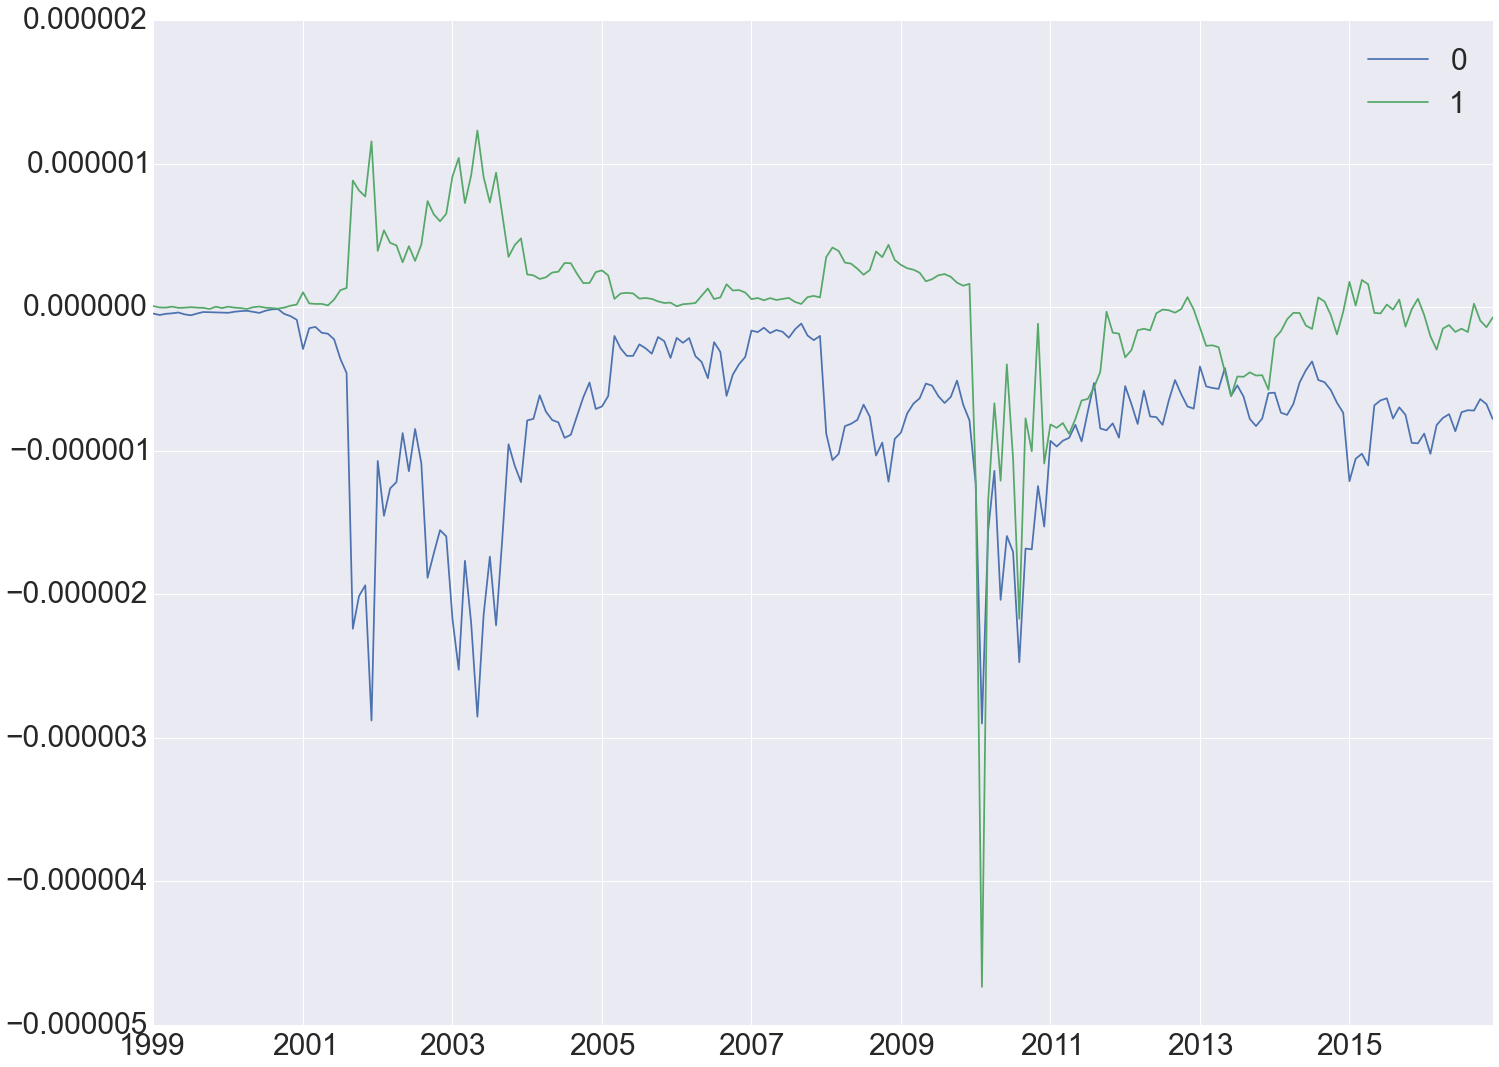

In [103]:
factor_rts=pd.DataFrame()
for i in range(0,components,1):
    q=pca.components_[i]
    factor_rts[i]=(q*temp.dropna()).sum(axis=1)
factor_rts.plot()

In [117]:
factor_rts
ind=factor_rts.index
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
VAR_PCA=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
VAR_PCA['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
VAR_PCA['PCA Factor']=factor_rts[0]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()


In [119]:
temp=VAR_PCA.ix[ind]

In [124]:
temp.columns
col=[ u'LIBOR', u'FedFunds', u'TED', u'FinancialStress', u'Pastor and Stambaugh (2003)', u'PCA Factor']

In [125]:
import statsmodels.tsa.vector_ar.var_model as VAR
res = VAR.VAR(endog=temp[col].dropna()).fit()
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Aug, 2017
Time:                     09:42:16
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -48.9726
Nobs:                     190.000    HQIC:                  -49.3996
Log likelihood:           3144.99    FPE:                2.62931e-22
AIC:                     -49.6903    Det(Omega_mle):     2.11625e-22
--------------------------------------------------------------------
Results for equation LIBOR
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                  0.112316         0.111581            1.007           0.315
L1.LIBOR                              -0.179874         0.090114           -1.996         

In [127]:
model = VAR.VAR(endog=temp[col].dropna())
model.select_order(14)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -39.36       -39.25    8.042e-18       -39.32
1        -50.59      -49.83*    1.074e-22      -50.28*
2        -50.71       -49.31    9.462e-23       -50.15
3        -50.94       -48.89    7.571e-23       -50.11
4        -51.10       -48.41    6.494e-23       -50.01
5        -51.42       -48.08    4.757e-23       -50.07
6        -51.56       -47.57    4.221e-23       -49.94
7        -51.59       -46.96    4.181e-23       -49.71
8        -52.07       -46.80    2.648e-23       -49.94
9        -52.14       -46.22    2.582e-23       -49.74
10       -52.05       -45.48    2.977e-23       -49.38
11       -52.33       -45.11   2.384e-23*       -49.40
12       -52.22       -44.36    2.869e-23       -49.03
13       -52.27       -43.77    2.986e-23       -48.82
14      -52.51*       -43.36    2.634e-23       -48.80
* Minimum


{'aic': 14, 'bic': 1, 'fpe': 11, 'hqic': 1}

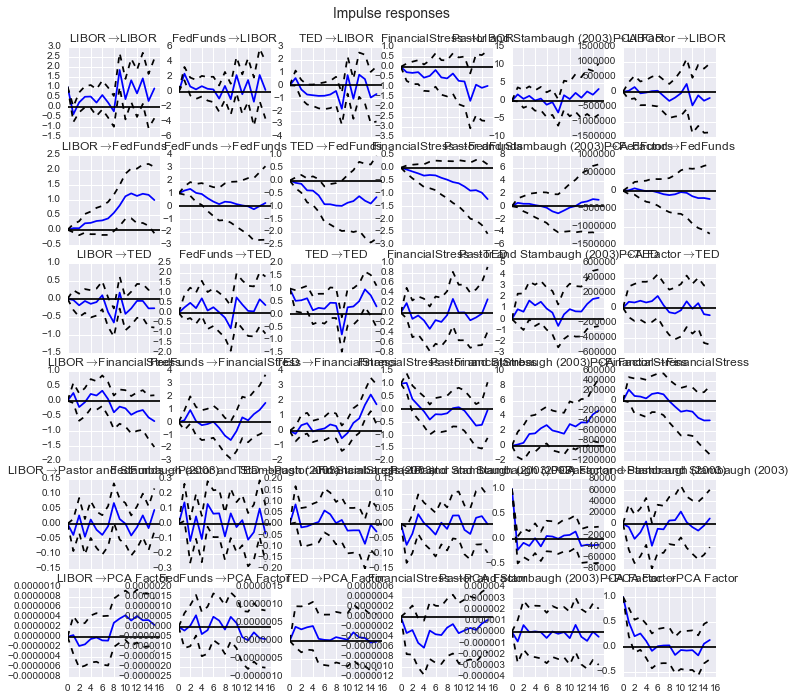

In [128]:
resaic = model.fit(maxlags=20,ic='aic')
irf=resaic.irf(15)
sns.set(font_scale=1)
irf.plot()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


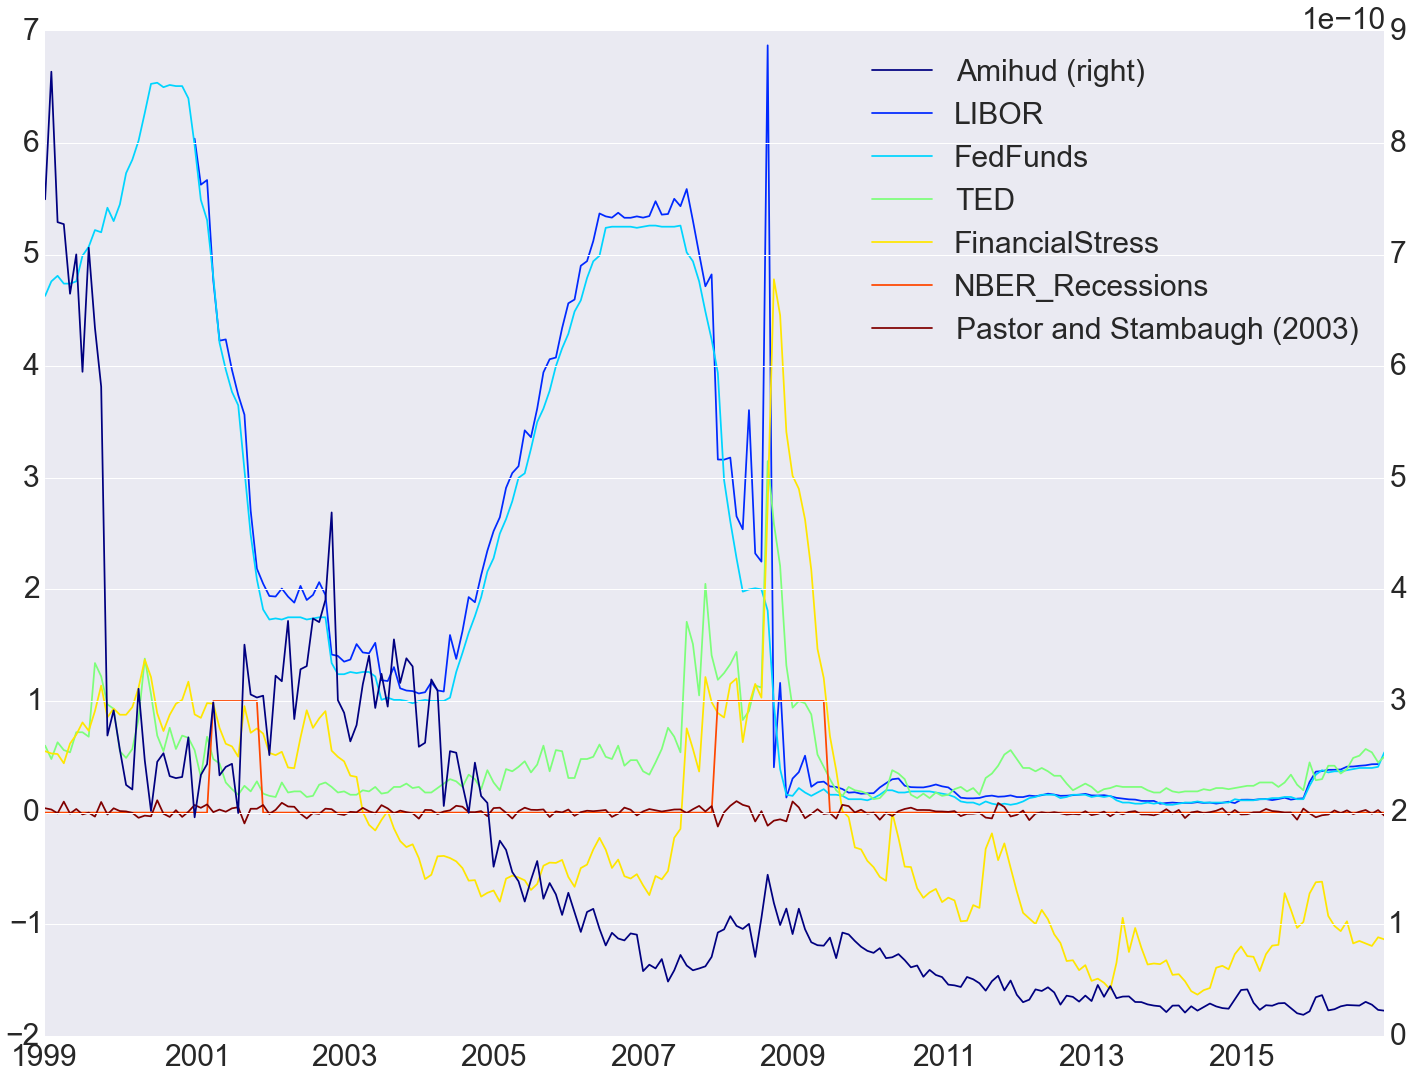

In [91]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
factors['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
factors.plot(secondary_y='Amihud',colormap='jet')

In [92]:
for i in range(0,components,1):
    factors['PCA Factor '+ str(i+1)]=factor_rts[i]

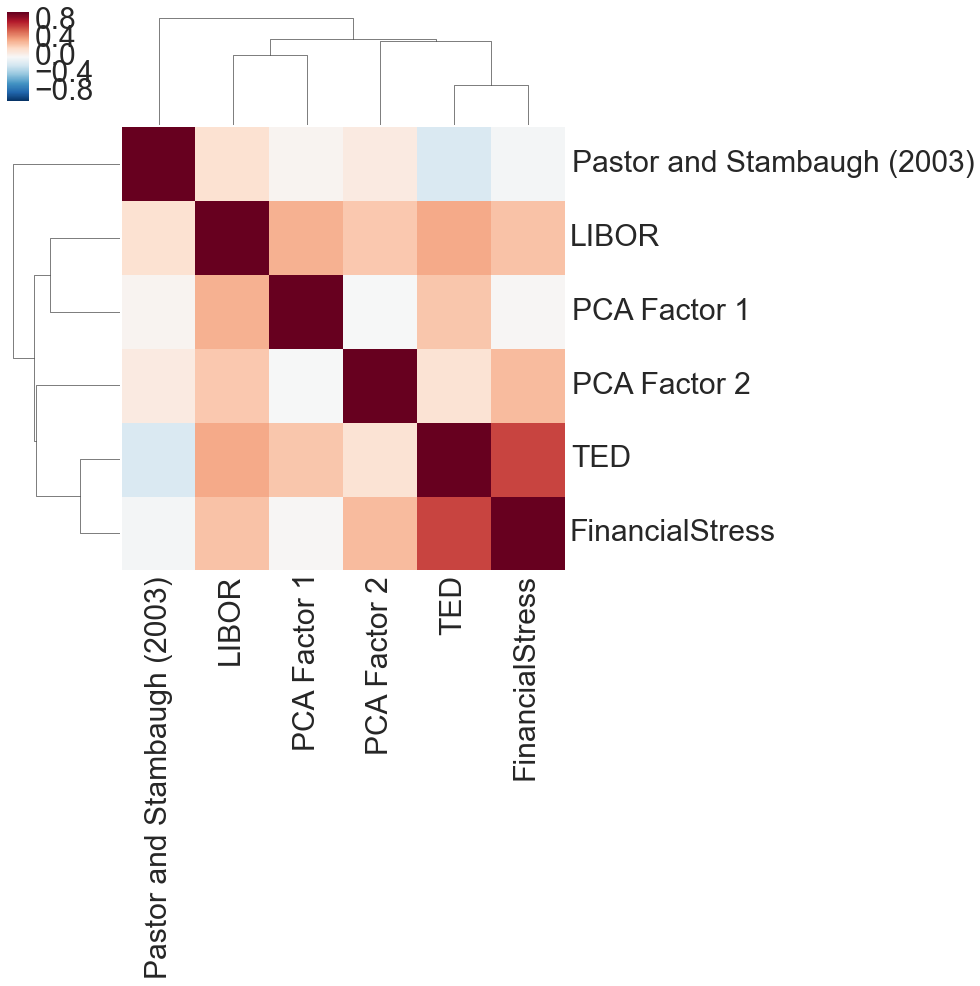

In [93]:
f=[u'LIBOR', u'TED', u'FinancialStress',
        u'Pastor and Stambaugh (2003)', u'PCA Factor 1',
       u'PCA Factor 2']
sns.clustermap(factors[f].corr())

In [94]:
f=[u'LIBOR', u'TED', u'FinancialStress',
        u'Pastor and Stambaugh (2003)']
factors['Intercept']=1
en=factors.dropna()

In [95]:
RES=pd.DataFrame()
for factor in f:
    res=sm.OLS(en['PCA Factor 1']*1e7,en[['Intercept',factor]]).fit()
    s=pd.Series()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Factor']=res.params[factor]
    s['Factor' + ' Tstat']=res.tvalues[factor]    
    s['R^2']=res.rsquared_adj
    RES[factor]=s   
RES.round(2)

,LIBOR,TED,FinancialStress,Pastor and Stambaugh (2003)
Intercept,-10.13,-9.49,-8.59,-8.39
Intercept Tstat,-19.87,-16.73,-20.71,-20.30
Factor,1.04,2.62,-0.82,2.97
Factor Tstat,5.19,2.78,-2.19,0.27
R^2,0.12,0.03,0.02,-0.00


In [96]:
print RES.round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  LIBOR &    TED &  FinancialStress &  Pastor and Stambaugh (2003) \\
\midrule
Intercept       & -10.13 &  -9.49 &            -8.59 &                        -8.39 \\
Intercept Tstat & -19.87 & -16.73 &           -20.71 &                       -20.30 \\
Factor          &   1.04 &   2.62 &            -0.82 &                         2.97 \\
Factor Tstat    &   5.19 &   2.78 &            -2.19 &                         0.27 \\
R\textasciicircum2             &   0.12 &   0.03 &             0.02 &                        -0.00 \\
\bottomrule
\end{tabular}



In [97]:
RES=pd.DataFrame()
for factor in f:
    res=sm.OLS(en['PCA Factor 2']*1e7,en[['Intercept',factor]]).fit()
    s=pd.Series()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Factor']=res.params[factor]
    s['Factor' + ' Tstat']=res.tvalues[factor]    
    s['R^2']=res.rsquared_adj
    RES[factor]=s   
RES.round(2)

,LIBOR,TED,FinancialStress,Pastor and Stambaugh (2003)
Intercept,-1.31,-0.85,0.51,-0.05
Intercept Tstat,-2.47,-1.46,1.27,-0.11
Factor,0.81,2.09,1.80,14.95
Factor Tstat,3.84,2.17,4.93,1.32
R^2,0.07,0.02,0.11,0.00


In [98]:
print RES.round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  LIBOR &   TED &  FinancialStress &  Pastor and Stambaugh (2003) \\
\midrule
Intercept       &  -1.31 & -0.85 &             0.51 &                        -0.05 \\
Intercept Tstat &  -2.47 & -1.46 &             1.27 &                        -0.11 \\
Factor          &   0.81 &  2.09 &             1.80 &                        14.95 \\
Factor Tstat    &   3.84 &  2.17 &             4.93 &                         1.32 \\
R\textasciicircum2             &   0.07 &  0.02 &             0.11 &                         0.00 \\
\bottomrule
\end{tabular}

